In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.manage_precipitation_data import create_tp_daily_summary, create_tp_monthly_aggregate, create_list_lat_long

In [42]:
from pathlib import Path


def create_daily_rainfall_dataframe(file_path = './output', location = 'london', debug = False):
    # retrieve all files for location
    folder_path = Path('./output')
    string_in_filename = location + '_daily'
    location_files = [f for f in folder_path.glob('*.parquet') if string_in_filename in f.name]
    
    # open each files and create a list of dataframe
    dfs = []
    for file in location_files:
        df = pd.read_parquet(file)
        dfs.append(df)

    # concat list of dataframes
    df_all = pd.concat(dfs, axis = 0).sort_values('time_dt').reset_index(drop=True)
    if debug:
        n_points = len(create_list_lat_long(df_all))
        n_days = ((df_all['time_dt'].max() - df_all['time_dt'].min()).days+1)
        print(f"number of expected rows = {n_points*n_days}, number of returned rows = {df_all.shape[0]}")
    return(df_all)

def transform_data_datetime(df):
    df = df.copy()
    df['year'] = df['time_dt'].dt.year
    df['month int'] = df['time_dt'].dt.month
    df['month'] = df['time_dt'].dt.strftime('%b')
    df['month'] = pd.Categorical(df['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

    df['day'] = df['time_dt'].dt.day


    return df

def get_monthly_stats(df_year_month):
    # Group by month_int (or month if you prefer month names)
    grouped = df_year_month.groupby('month int', observed=True)
    
    # Calculate basic statistics
    stats = grouped['tp_monthly_sum'].agg([
        'sum', 'median', 'mean', 'std', 'min', 'max'
    ]).round(2)
    
    # Find years when min and max occurred
    min_years = grouped.apply(lambda x: x.loc[x['tp_monthly_sum'].idxmin(), 'year'], include_groups=False)
    max_years = grouped.apply(lambda x: x.loc[x['tp_monthly_sum'].idxmax(), 'year'], include_groups=False)
    
    # Combine everything into final dataframe
    result = stats.copy()
    result['min_year'] = min_years
    result['max_year'] = max_years
    
    # Add month names for readability (optional)
    month_names = df_year_month.groupby('month int', observed = True)['month'].first()
    result['month_name'] = month_names
    
    # Reorder columns for better readability
    result = result[['month_name', 'sum', 'median', 'mean', 'std', 'min', 'max', 'min_year', 'max_year']]
    
    return result.reset_index(drop = True).rename(columns = {'month_name': 'month',
                                                             'sum': 'month_sum',
                                                           'median': 'month_median',
                                                           'mean': 'month_avg',
                                                           'std': 'month_std',
                                                           'min': 'month_min',
                                                           'max': 'month_max'})


def thresholding_and_rounding(series, threshold = 0.1):
    s1 = series.copy()
    s1[s1 < threshold] = 0
    return(np.round(s1,1))

def create_monthly_aggregate(location = 'london', remove_date_list = ['2009-12-31'], debug = False, save_parquet = True):
    '''
    Create function signature    
    '''

    # first, create daily total precipitation for all points in the grid
    # in the area defined by location. This data is contained in pickle files 
    # from a specific folder. The function concat all yearly files created in
    # previous steps
    df_data = create_daily_rainfall_dataframe(location=location, debug=debug)
    if debug:
        print(df_data[df_data['time'] == df_data['time'].min()])
    # removing data contained in remove_date_list
    df_data = df_data[~df_data['time'].isin(remove_date_list)].reset_index(drop=True).copy()

    # creating time_dt column to process the mean
    df_data = transform_data_datetime(df_data)

    # Averaging measurements for all points in the grid
    df_data_mean = (df_data
                        .groupby('time_dt')['tp_mm']
                        .mean()
                        ).reset_index()

    # creating year, month, day colums
    df_data_mean = transform_data_datetime(df_data_mean)
    # thresholding and rounding tp_mm values
    df_data_mean['tp_mm'] = thresholding_and_rounding(df_data_mean['tp_mm'])
    # creating year-month aggregate - to decide if saving the result as a parquet file for further analysis on time/monthly series
    # At this stage, we are just using the monthly sum
    df_data_year_month = (df_data_mean
                            .groupby(['year', 'month int'])
                            .agg(
                                month = ('month', 'first'),
                                tp_monthly_sum = ('tp_mm', 'sum'),
                                tp_daily_median = ('tp_mm', 'median'),
                                tp_daily_avg = ('tp_mm', 'mean'),
                                tp_daily_std = ('tp_mm', 'std'),
                                tp_daily_min = ('tp_mm', 'min'),
                                tp_daily_max = ('tp_mm', 'max')
                                ).reset_index()
                                )
    
    # creating the 'year_month' as string variable - this is just if we want to save the resulting dataframe for further analysis
    df_data_year_month['year_month'] = df_data_year_month['year'].astype(str) + '-' + df_data_year_month['month int'].astype(str).str.zfill(2)
    
    filename_str = location + '_year_month_from_' + df_data_year_month['year_month'].min() + '_to_' + df_data_year_month['year_month'].max()
    if debug:
        print(filename_str)
    
    
    # finally, creating monthly aggregate

    data_monthly_tp = get_monthly_stats(df_data_year_month)
                        #  .groupby('month', observed=True)
                        #  .agg(
                        #      month_sum = ('tp_monthly_sum', 'sum'),
                        #      month_median = ('tp_monthly_sum', 'median'),
                        #      month_avg = ('tp_monthly_sum', 'mean'),
                        #      month_std = ('tp_monthly_sum', 'std'),
                        #      month_min = ('tp_monthly_sum', 'min'),
                        #      month_max = ('tp_monthly_sum', 'max')
                        #      )
                        #      .reset_index()
                        #      )
    
#    data_monthly_tp[['month_median', 'month_avg','month_std']] = np.round(data_monthly_tp[['month_median', 'month_avg','month_std']],1)    

    if save_parquet:
        df_data_year_month.to_parquet(f'../streamlit/data/{filename_str}.parquet', index=False)
        data_monthly_tp.to_parquet(f'../streamlit/data/{location}_monthly_aggregate.parquet', index=False)

    return(df_data_year_month, data_monthly_tp)

import matplotlib.pyplot as plt
import numpy as np

# Example data
def plot_monthly_aggregate_static(df_plot, feature_label = 'Mean', bar_width = 0.35, location = 'London'):
    label_dict = {'Mean':'month_avg', 'Median':'month_median', 'Sum':'month_sum', 'Avg' :'month_avg', 'Average':'month_avg'}
    feature = label_dict[feature_label]
    months = df_plot['month'].values
    # agg_precip = df_plot[feature].values
    min_precip = df_plot['month_min'].values
    max_precip = df_plot['month_max'].values

    # Convert months to x-axis positions
    x = np.arange(len(months))

    # Plot
    plt.figure(figsize=(10, 4))
    # plt.plot(x, agg_precip, label='Mean Precipitation', color='blue', marker='o')
    print(feature)
    ax = sns.barplot(data = df_plot, 
                x = 'month', 
                y = feature,
                width=0.5)

    plt.plot(x, max_precip, label='Max Precipitation', color='red', marker='o')
    plt.fill_between(x, min_precip, max_precip, color='lightblue', alpha=0.4, label='Min-Max Range')
    plt.plot(x, min_precip, label='Min Precipitation', color='green', marker='d')

    # Add annotations on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

    # Move legend outside the plot
    ax.legend(
        title='Aggregate Values',
        bbox_to_anchor=(1.05, 1),  # x=1.05 moves it to the right
        loc='upper left',          # anchor point of the legend
        borderaxespad=0.
    )

    plt.xticks(x, months)
    plt.ylabel("Precipitation (mm)")
    plt.title(f"Monthly {feature_label} Rainfall with Min-Max Range in {location}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_monthly_aggregate_overlaid(df1, df2,
                                    label1='Dataset 1',
                                    label2='Dataset 2',
                                    feature_label='Mean',
                                    bar_width=0.35,
                                    location='Comparison',
                                    fig_width=1000,
                                    fig_height=500,
                                    dark_mode=False,
                                    show_title = True):
    fig = go.Figure()

    label_dict = {'Mean': 'month_avg', 'Median': 'month_median',
                  'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'}
    feature = label_dict[feature_label]

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Colorblind-safe palette
    bar_color1 = '#0072B2'; min_color1 = '#D55E00'; max_color1 = '#009E73'
    bar_color2 = '#E69F00'; min_color2 = '#56B4E9'; max_color2 = '#CC79A7'
    fill_color1 = 'rgba(100, 100, 100, 0.1)'
    fill_color2 = 'rgba(150, 150, 150, 0.1)'
    grid_color = 'gray' if dark_mode else 'lightgray'
    text_color = 'white' if dark_mode else 'black'

    # Dataset 1 values
    mean1 = df1[feature].values
    min1 = df1['month_min'].values
    max1 = df1['month_max'].values

    # Dataset 2 values
    mean2 = df2[feature].values
    min2 = df2['month_min'].values
    max2 = df2['month_max'].values

    # --- Fill Areas (Optional) ---
    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max1) + list(min1[::-1]),
        fill='toself',
        fillcolor=fill_color1,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label1} Min-Max Range'
    ))

    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max2) + list(min2[::-1]),
        fill='toself',
        fillcolor=fill_color2,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label2} Min-Max Range'
    ))

    # --- Bars for Dataset 1 ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean1,
        name=f'{label1} {feature_label}',
        marker=dict(color=bar_color1),
        width=bar_width,
        offsetgroup=0,
        hovertemplate=f'{label1} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    # --- Bars for Dataset 2 ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean2,
        name=f'{label2} {feature_label}',
        marker=dict(color=bar_color2),
        width=bar_width,
        offsetgroup=1,
        hovertemplate=f'{label2} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    # --- Min/Max lines for Dataset 1 ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min1,
        mode='lines+markers',
        name=f'{label1} Min',
        line=dict(color=min_color1, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color1),
        hovertemplate=f'{label1} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max1,
        mode='lines+markers',
        name=f'{label1} Max',
        line=dict(color=max_color1, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color1),
        hovertemplate=f'{label1} Max: %{{y:.1f}}<extra></extra>'
    ))

    # --- Min/Max lines for Dataset 2 ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min2,
        mode='lines+markers',
        name=f'{label2} Min',
        line=dict(color=min_color2, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color2),
        hovertemplate=f'{label2} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max2,
        mode='lines+markers',
        name=f'{label2} Max',
        line=dict(color=max_color2, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color2),
        hovertemplate=f'{label2} Max: %{{y:.1f}}<extra></extra>'
    ))

    # --- Layout ---
    layout_params = {
    'xaxis_title': 'Month',
    'yaxis_title': 'Precipitation (mm)',
    'template': 'plotly_dark' if dark_mode else 'plotly_white',
    'hovermode': 'x unified',
    'barmode': 'group',
    'width': fig_width,
    'height': fig_height,
    'font': dict(color=text_color),
    'xaxis': dict(
        showgrid=True,
        gridcolor=grid_color,
    ),
    'yaxis': dict(
        showgrid=True,
        gridcolor=grid_color,
    ),
    'legend': dict(
        bgcolor='rgba(0,0,0,0)' if dark_mode else 'rgba(255,255,255,0)',
        borderwidth=0
    )
}

    if show_title:
        layout_params['title'] = f"{feature_label} Monthly Rainfall Comparison in {location}"
    else:
        layout_params['title'] = ""
        layout_params['margin'] = dict(t=60)  # Reduce top margin when no title

    fig.update_layout(**layout_params)

    return fig

In [66]:
metric = 'Mean'

fig = plot_monthly_aggregate_overlaid(london_monthly_aggregate, apulia_monthly_aggregate,
                            label1='London',
                            label2='Apulia',
                            feature_label=metric,
                            bar_width=0.35,
                            location='Comparison',
                            fig_width=900,
                            fig_height=500,
                            dark_mode=True,
                            show_title=False)

In [67]:
fig.show()

In [43]:
# london_monthly_aggregate = create_monthly_aggregate(remove_date_list = ['1999-12-31'],debug=False)
# apulia_monthly_aggregate = create_monthly_aggregate('puglia',remove_date_list = ['1999-12-31'], debug=False)

In [44]:
london_year_month, london_monthly_aggregate = create_monthly_aggregate(remove_date_list = ['1999-12-31'],debug=False, save_parquet=False)
apulia_year_month, apulia_monthly_aggregate = create_monthly_aggregate(location='puglia', remove_date_list = ['1999-12-31'],debug=False, save_parquet=False)

In [45]:
london_monthly_aggregate

,month,month_sum,month_median,month_avg,month_std,month_min,month_max,min_year,max_year
0,Jan,1546.9,57.60,59.50,25.25,17.9,114.4,2000,2021
1,Feb,1407.4,48.75,54.13,27.42,9.7,116.1,2023,2024
2,Mar,1304.3,45.90,50.17,28.31,12.1,114.9,2011,2001
3,Apr,1289.9,43.65,49.61,29.91,5.2,119.2,2011,2000
4,May,1594.8,54.65,61.34,27.45,6.3,110.7,2020,2007
5,Jun,1587.3,49.15,61.05,36.50,8.6,136.8,2018,2012
6,Jul,1693.9,70.20,67.76,24.99,16.3,116.5,2022,2012
7,Aug,1681.8,65.00,67.27,28.14,17.0,125.4,2003,2004
8,Sep,1214.1,47.80,48.56,26.98,15.4,132.4,2003,2024
9,Oct,1730.9,62.40,69.24,33.94,22.3,143.3,2011,2000


,month,month_sum,month_median,month_avg,month_std,month_min,month_max,min_year,max_year
0,Jan,1620.6,60.05,62.33,36.29,9.7,165.5,2020,2009
1,Feb,1477.3,55.75,56.82,28.41,11.8,126.8,2023,2012
2,Mar,1690.9,62.45,65.03,29.25,18.2,125.9,2001,2016
3,Apr,1495.0,53.45,57.50,24.50,16.5,116.8,2018,2009
4,May,1209.3,40.00,46.51,27.11,11.8,122.5,2021,2023
5,Jun,864.3,31.40,33.24,22.93,0.7,80.9,2012,2004
6,Jul,527.0,19.60,21.08,16.78,2.5,78.0,2007,2002
7,Aug,570.9,16.30,22.84,19.86,2.0,71.8,2012,2018
8,Sep,1455.3,57.10,58.21,30.54,11.4,141.9,2013,2016
9,Oct,1682.9,51.00,67.32,42.42,20.4,162.8,2008,2010


In [63]:
london_year_month.head()

,year,month int,month,tp_monthly_sum,tp_daily_median,tp_daily_avg,tp_daily_std,tp_daily_min,tp_daily_max,year_month
0,2000,1,Jan,17.9,0.00,0.577419,1.558570,0.0,8.4,2000-01
1,2000,2,Feb,73.3,1.60,2.527586,3.099527,0.0,11.6,2000-02
2,2000,3,Mar,26.1,0.00,0.841935,1.397802,0.0,4.6,2000-03
3,2000,4,Apr,119.2,3.05,3.973333,3.849311,0.0,12.2,2000-04
4,2000,5,May,97.4,1.00,3.141935,4.606935,0.0,17.4,2000-05


In [62]:
# # Group by month and calculate all statistics
# def get_monthly_stats(df_year_month):
#     # Group by month_int (or month if you prefer month names)
#     grouped = df_year_month.groupby('month int', observed=True)
    
#     # Calculate basic statistics
#     stats = grouped['tp_monthly_sum'].agg([
#         'sum', 'median', 'mean', 'std', 'min', 'max'
#     ]).round(2)
    
#     # Find years when min and max occurred
#     min_years = grouped.apply(lambda x: x.loc[x['tp_monthly_sum'].idxmin(), 'year'], include_groups=False)
#     max_years = grouped.apply(lambda x: x.loc[x['tp_monthly_sum'].idxmax(), 'year'], include_groups=False)
    
#     # Combine everything into final dataframe
#     result = stats.copy()
#     result['min_year'] = min_years
#     result['max_year'] = max_years
    
#     # Add month names for readability (optional)
#     month_names = df_year_month.groupby('month int', observed = True)['month'].first()
#     result['month_name'] = month_names
    
#     # Reorder columns for better readability
#     result = result[['month_name', 'sum', 'median', 'mean', 'std', 'min', 'max', 'min_year', 'max_year']]
    
#     return result.reset_index(drop = True).rename(columns = {'month_name': 'month',
#                                                              'sum': 'month_sum',
#                                                            'median': 'month_median',
#                                                            'mean': 'month_avg',
#                                                            'std': 'month_std',
#                                                            'min': 'month_min',
#                                                            'max': 'month_max'})

In [39]:
monthly_stats = get_monthly_stats(london_year_month)

In [40]:
monthly_stats

,month,month_sum,month_median,month_avg,month_std,month_min,month_max,min_year,max_year
0,Jan,1546.9,57.60,59.50,25.25,17.9,114.4,2000,2021
1,Feb,1407.4,48.75,54.13,27.42,9.7,116.1,2023,2024
2,Mar,1304.3,45.90,50.17,28.31,12.1,114.9,2011,2001
3,Apr,1289.9,43.65,49.61,29.91,5.2,119.2,2011,2000
4,May,1594.8,54.65,61.34,27.45,6.3,110.7,2020,2007
5,Jun,1587.3,49.15,61.05,36.50,8.6,136.8,2018,2012
6,Jul,1693.9,70.20,67.76,24.99,16.3,116.5,2022,2012
7,Aug,1681.8,65.00,67.27,28.14,17.0,125.4,2003,2004
8,Sep,1214.1,47.80,48.56,26.98,15.4,132.4,2003,2024
9,Oct,1730.9,62.40,69.24,33.94,22.3,143.3,2011,2000


In [41]:
london_monthly_aggregate

,month,month_sum,month_median,month_avg,month_std,month_min,month_max
0,Jan,1546.9,57.6,59.5,25.2,17.9,114.4
1,Feb,1407.4,48.8,54.1,27.4,9.7,116.1
2,Mar,1304.3,45.9,50.2,28.3,12.1,114.9
3,Apr,1289.9,43.6,49.6,29.9,5.2,119.2
4,May,1594.8,54.6,61.3,27.4,6.3,110.7
5,Jun,1587.3,49.2,61.0,36.5,8.6,136.8
6,Jul,1693.9,70.2,67.8,25.0,16.3,116.5
7,Aug,1681.8,65.0,67.3,28.1,17.0,125.4
8,Sep,1214.1,47.8,48.6,27.0,15.4,132.4
9,Oct,1730.9,62.4,69.2,33.9,22.3,143.3


In [19]:
monthly_stats.reset_index()

,month int,month_name,sum,median,mean,std,min,max,min_year,max_year
0,1,Jan,1546.9,57.60,59.50,25.25,17.9,114.4,2000,2021
1,2,Feb,1407.4,48.75,54.13,27.42,9.7,116.1,2023,2024
2,3,Mar,1304.3,45.90,50.17,28.31,12.1,114.9,2011,2001
3,4,Apr,1289.9,43.65,49.61,29.91,5.2,119.2,2011,2000
4,5,May,1594.8,54.65,61.34,27.45,6.3,110.7,2020,2007
5,6,Jun,1587.3,49.15,61.05,36.50,8.6,136.8,2018,2012
6,7,Jul,1693.9,70.20,67.76,24.99,16.3,116.5,2022,2012
7,8,Aug,1681.8,65.00,67.27,28.14,17.0,125.4,2003,2004
8,9,Sep,1214.1,47.80,48.56,26.98,15.4,132.4,2003,2024
9,10,Oct,1730.9,62.40,69.24,33.94,22.3,143.3,2011,2000


In [9]:
london_monthly_aggregate

,month,month_sum,month_median,month_avg,month_std,month_min,month_max
0,Jan,1546.9,57.6,59.5,25.2,17.9,114.4
1,Feb,1407.4,48.8,54.1,27.4,9.7,116.1
2,Mar,1304.3,45.9,50.2,28.3,12.1,114.9
3,Apr,1289.9,43.6,49.6,29.9,5.2,119.2
4,May,1594.8,54.6,61.3,27.4,6.3,110.7
5,Jun,1587.3,49.2,61.0,36.5,8.6,136.8
6,Jul,1693.9,70.2,67.8,25.0,16.3,116.5
7,Aug,1681.8,65.0,67.3,28.1,17.0,125.4
8,Sep,1214.1,47.8,48.6,27.0,15.4,132.4
9,Oct,1730.9,62.4,69.2,33.9,22.3,143.3


In [ ]:
london_year_month.head()

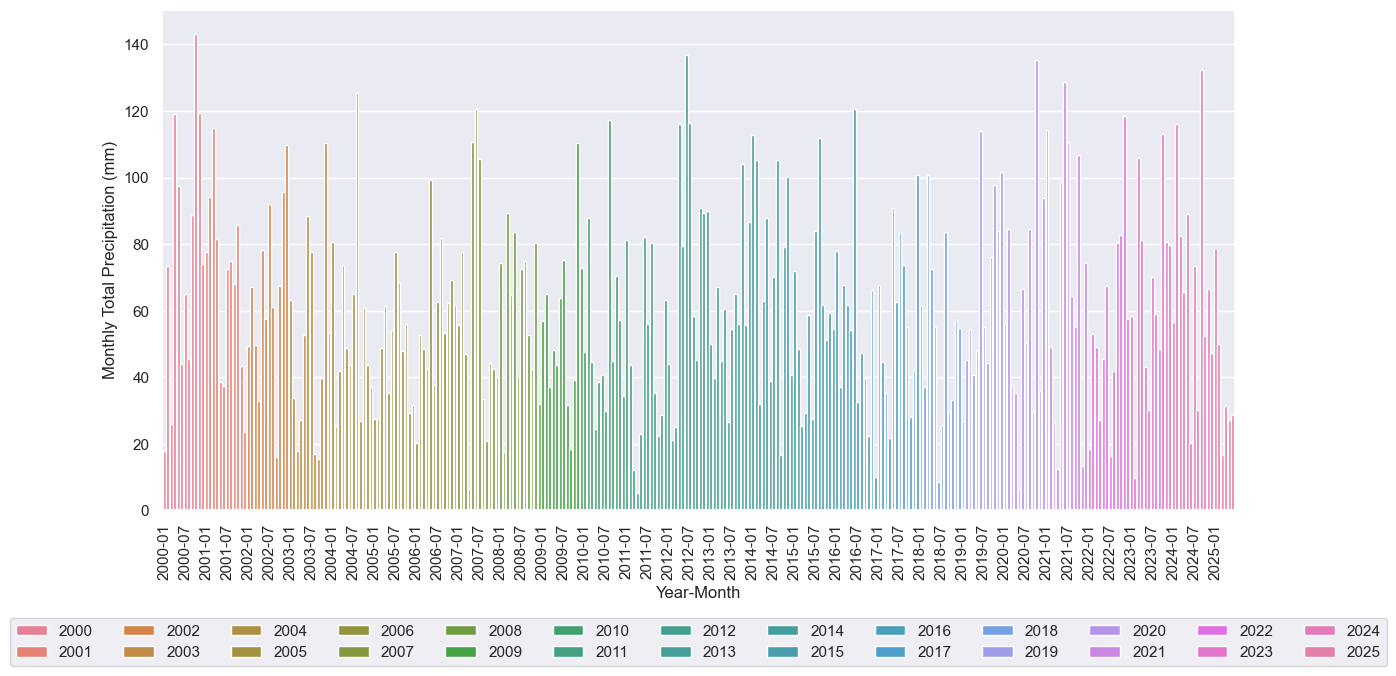

In [47]:
# This creates a more systematic approach
n_years = london_year_month['year'].nunique()
colors = sns.color_palette("husl", n_years)  # or "Set1", "Dark2", etc.

sns.set_theme(rc={'figure.figsize':(14.,7.)})
# sns.barplot(data = london_year_month, x='year_month', y='tp_monthly_sum', hue = 'year', palette='tab20', legend = False);
sns.barplot(data=london_year_month, x='year_month', y='tp_monthly_sum', 
            hue='year', palette=colors)

## Show only every 6th label
xticks = london_year_month['year_month'].unique()
plt.xticks(
    ticks=range(0, len(xticks), 6),
    labels=xticks[::6],
    rotation=90
)

plt.xlabel('Year-Month')
plt.ylabel('Monthly Total Precipitation (mm)')

# Move legend outside and make it horizontal
plt.legend(bbox_to_anchor=(0.5, -0.20), loc='upper center', ncol=13)  # Adjust ncol as needed

plt.tight_layout()
plt.show();

In [48]:
london_year_month[london_year_month['tp_monthly_sum'] == london_year_month['tp_monthly_sum'].min()]

,year,month int,month,tp_monthly_sum,tp_daily_median,tp_daily_avg,tp_daily_std,tp_daily_min,tp_daily_max,year_month
135,2011,4,Apr,5.2,0.0,0.173333,0.418481,0.0,1.9,2011-04


In [50]:
apulia_year_month[apulia_year_month['tp_monthly_sum'] == apulia_year_month['tp_monthly_sum'].min()]

,year,month int,month,tp_monthly_sum,tp_daily_median,tp_daily_avg,tp_daily_std,tp_daily_min,tp_daily_max,year_month
149,2012,6,Jun,0.7,0.0,0.023333,0.089763,0.0,0.4,2012-06


In [51]:
london_monthly_aggregate

,month,month_sum,month_median,month_avg,month_std,month_min,month_max,min_year,max_year
0,Jan,1546.9,57.60,59.50,25.25,17.9,114.4,2000,2021
1,Feb,1407.4,48.75,54.13,27.42,9.7,116.1,2023,2024
2,Mar,1304.3,45.90,50.17,28.31,12.1,114.9,2011,2001
3,Apr,1289.9,43.65,49.61,29.91,5.2,119.2,2011,2000
4,May,1594.8,54.65,61.34,27.45,6.3,110.7,2020,2007
5,Jun,1587.3,49.15,61.05,36.50,8.6,136.8,2018,2012
6,Jul,1693.9,70.20,67.76,24.99,16.3,116.5,2022,2012
7,Aug,1681.8,65.00,67.27,28.14,17.0,125.4,2003,2004
8,Sep,1214.1,47.80,48.56,26.98,15.4,132.4,2003,2024
9,Oct,1730.9,62.40,69.24,33.94,22.3,143.3,2011,2000


In [52]:
apulia_monthly_aggregate

,month,month_sum,month_median,month_avg,month_std,month_min,month_max,min_year,max_year
0,Jan,1620.6,60.05,62.33,36.29,9.7,165.5,2020,2009
1,Feb,1477.3,55.75,56.82,28.41,11.8,126.8,2023,2012
2,Mar,1690.9,62.45,65.03,29.25,18.2,125.9,2001,2016
3,Apr,1495.0,53.45,57.50,24.50,16.5,116.8,2018,2009
4,May,1209.3,40.00,46.51,27.11,11.8,122.5,2021,2023
5,Jun,864.3,31.40,33.24,22.93,0.7,80.9,2012,2004
6,Jul,527.0,19.60,21.08,16.78,2.5,78.0,2007,2002
7,Aug,570.9,16.30,22.84,19.86,2.0,71.8,2012,2018
8,Sep,1455.3,57.10,58.21,30.54,11.4,141.9,2013,2016
9,Oct,1682.9,51.00,67.32,42.42,20.4,162.8,2008,2010


In [53]:
# # year for each monthly minimum London
# label = 'month_min'
# year_label = 'year_min'
# london_month_year_min = (london_year_month[['year','month', 'tp_monthly_sum']]
#  .merge(london_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#  .sort_values('month')
#  .rename(columns = {'year': year_label})
#  .reset_index(drop = True)
# )[['month','tp_monthly_sum',year_label]]

# # year for each monthly maximum London
# label = 'month_max'
# year_label = 'year_max'
# london_month_year_max = (london_year_month[['year','month', 'tp_monthly_sum']]
#  .merge(london_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#  .sort_values('month')
#  .rename(columns = {'year': year_label})
#  .reset_index(drop = True)
# )[['month','tp_monthly_sum',year_label]]

# # year for each monthly minimum Apulia
# label = 'month_min'
# year_label = 'year_min'
# apulia_month_year_min = (apulia_year_month[['year','month', 'tp_monthly_sum']]
#  .merge(apulia_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#  .sort_values('month')
#  .rename(columns = {'year': year_label})
#  .reset_index(drop = True)
# )[['month','tp_monthly_sum',year_label]]

# # year for each monthly maximum Apulia
# label = 'month_max'
# year_label = 'year_max'
# apulia_month_year_max = (apulia_year_month[['year','month', 'tp_monthly_sum']]
#  .merge(apulia_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#  .sort_values('month')
#  .rename(columns = {'year': year_label})
#  .reset_index(drop = True)
# )[['month','tp_monthly_sum',year_label]]


In [54]:
# def tp_monthly_sum_year_minmax(df_monthly_aggregate, df_year_month):
#     """
#     This function returns two dataframes containing the years in which 
#     the minimum and maximum monthly total precipitation occurred.
#     """
    
#     # min
#     label = 'month_min'
#     year_label = 'year_min'
#     df_month_year_min = (df_year_month[['year','month', 'tp_monthly_sum']]
#                          .merge(df_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#                          .sort_values('month')
#                          .rename(columns = {'year': year_label})
#                          .reset_index(drop = True)
#                          )[['month','tp_monthly_sum',year_label]]
    
#     # max
#     label = 'month_max'
#     year_label = 'year_max'
#     df_month_year_max = (df_year_month[['year','month', 'tp_monthly_sum']]
#                          .merge(df_monthly_aggregate[label], how='inner', left_on='tp_monthly_sum', right_on=label)
#                          .sort_values('month')
#                          .rename(columns = {'year': year_label})
#                          .reset_index(drop = True)
#                          )[['month','tp_monthly_sum',year_label]]
    
#     return df_month_year_min, df_month_year_max
    

In [55]:
# test_london_month_year_min, test_london_month_year_max = tp_monthly_sum_year_minmax(london_monthly_aggregate, london_year_month)

In [56]:
# def merge_monthly_aggregate_with_minmax(df_monthly_aggregate, df_year_min, df_year_max):
#     """
#     This function merges the monthly aggregate with dataframes containing the years 
#     where the minimum and maximum monthly total precipitation occurrred
#     """
#     df_merged = df_monthly_aggregate.merge(
#         df_year_min,
#         left_on=['month', 'month_min'],
#         right_on=['month', 'tp_monthly_sum'],
#         how='left'
#         )

#     df_merged.drop(columns=['tp_monthly_sum'], inplace=True)

#     df_final = df_merged.merge(
#         df_year_max,
#         left_on=['month', 'month_max'],
#         right_on=['month', 'tp_monthly_sum'],
#         how='left'
#         )

#     df_final.drop(columns=['tp_monthly_sum'], inplace=True)
#     return(df_final)

In [57]:
# test = merge_monthly_aggregate_with_minmax(london_monthly_aggregate, test_london_month_year_min, test_london_month_year_max)
# test

## Min and Max years analysis

We now want to create a column that, for each max and month, indicatest in which year it happened.

In [ ]:
london_daily = create_daily_rainfall_dataframe(location='london', debug=False)
apulia_daily = create_daily_rainfall_dataframe(location='puglia', debug=False)

In [ ]:
london_daily = transform_data_datetime(london_daily)

# Averaging measurements for all points in the grid
london_daily_mean = (london_daily
                    .groupby('time_dt')['tp_mm']
                    .mean()
                    ).reset_index()

# creating year, month, day colums
london_daily_mean = transform_data_datetime(london_daily_mean)
# thresholding and rounding tp_mm values
london_daily_mean['tp_mm'] = thresholding_and_rounding(london_daily_mean['tp_mm'])

In [ ]:
london_daily_mean.head()

In [ ]:
london_year_month = (london_daily_mean
                        .groupby(['year', 'month int'])
                        .agg(
                            month = ('month', 'first'),
                            tp_monthly_sum = ('tp_mm', 'sum'),
                            tp_daily_median = ('tp_mm', 'median'),
                            tp_daily_avg = ('tp_mm', 'mean'),
                            tp_daily_std = ('tp_mm', 'std'),
                            tp_daily_min = ('tp_mm', 'min'),
                            tp_daily_max = ('tp_mm', 'max')
                            ).reset_index()
                            )


In [ ]:
london_monthly_tp = (london_year_month
                         .groupby('month', observed=True)
                         .agg(
                             month_sum = ('tp_monthly_sum', 'sum'),
                             month_median = ('tp_monthly_sum', 'median'),
                             month_avg = ('tp_monthly_sum', 'mean'),
                             month_std = ('tp_monthly_sum', 'std'),
                             month_min = ('tp_monthly_sum', 'min'),
                             month_max = ('tp_monthly_sum', 'max')
                             )
                             .reset_index()
                             )

In [ ]:
london_monthly_tp

In [ ]:
london_year_month[['year','month', 'tp_monthly_sum']].merge(london_monthly_tp['month_min'], how='inner', left_on='tp_monthly_sum', right_on='month_min').sort_values('month')

In [ ]:
london_year_month[['year','month', 'tp_monthly_sum']].merge(london_monthly_tp['month_max'], how='inner', left_on='tp_monthly_sum', right_on='month_max').sort_values('month')

In [ ]:
london_monthly_aggregate = create_monthly_aggregate(debug=True)
apulia_monthly_aggregate = create_monthly_aggregate('puglia', debug=True)

In [ ]:
london_monthly_aggregate.to_parquet('../streamlit/data/london_monthly_aggregate.parquet')
apulia_monthly_aggregate.to_parquet('../streamlit/data/apulia_monthly_aggregate.parquet')

In [ ]:
london_monthly_aggregate.head()

In [ ]:
london_monthly_aggregate[london_monthly_aggregate['month_avg'] == london_monthly_aggregate['month_avg'].max()]

In [ ]:
apulia_monthly_aggregate

month_avg


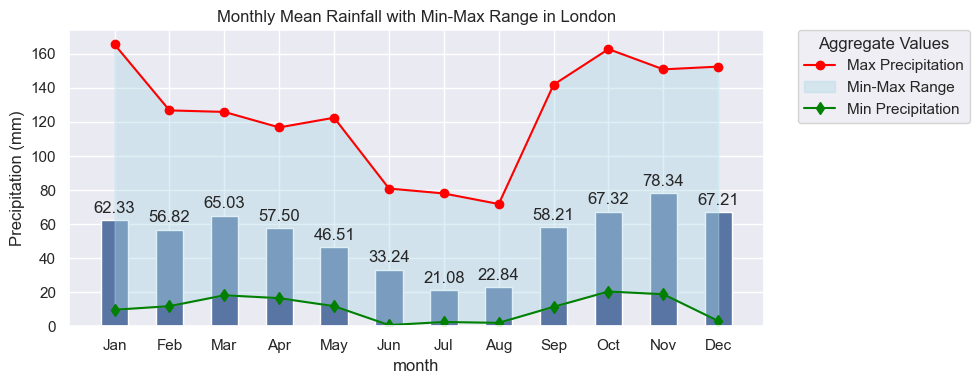

In [58]:
plot_monthly_aggregate_static(apulia_monthly_aggregate, 'Mean')

In [ ]:
plot_monthly_aggregate_static(london_monthly_aggregate, 'Mean')

In [59]:
import plotly.graph_objects as go


def plot_monthly_aggregate_dynamic(df_plot, 
                                   feature_label = 'Mean', 
                                   bar_width = 0.35, 
                                   location = 'London',
                                   fig_width = 800,
                                   fig_height = 400):
    # Create figure
    fig = go.Figure()

    label_dict = {'Mean':'month_avg', 'Median':'month_median', 'Sum':'month_sum', 'Avg' :'month_avg', 'Average':'month_avg'}
    feature = label_dict[feature_label]

    months = df_plot['month'].values
    mean_precip = df_plot[feature].values
    min_precip = df_plot['month_min'].values
    max_precip = df_plot['month_max'].values


    # Add min-max range as a filled area
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    fig.add_trace(go.Scatter(
        x=months + months[::-1],  # x: Jan to Dec and back from Dec to Jan
        y=list(max_precip) + list(min_precip[::-1]),  # Upper bound + lower bound reversed
        fill='toself',
        fillcolor='rgba(135, 206, 250, 0.4)',  # Light blue with transparency
        line=dict(color='rgba(255,255,255,0)'),  # No line
        hoverinfo="skip",
        showlegend=True,
        name='Min-Max Range'
    ))

    # Add mean line
    # fig.add_trace(go.Scatter(
    #     x=months,
    #     y=mean_precip,
    #     mode='lines+markers',
    #     name='Mean Precipitation',
    #     line=dict(color='blue'),
    #     marker=dict(size=6)
    # ))

    fig.add_trace(go.Bar(
        x = months,
        y = mean_precip,
        name='Mean Precipitation',
        marker=dict(
            color='blue',
            line=dict(width=0),
            opacity=0.9
        ),
        width=bar_width
    ))

    # Layout
    fig.update_layout(
        title = f"Monthly {feature_label} Rainfall with Min-Max Range in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_white',
        hovermode="x unified",
        barmode='overlay',
        barcornerradius=8,
        width=fig_width,
        height=fig_height,
    )

    return(fig)

In [60]:
plot_monthly_aggregate_dynamic(london_monthly_aggregate, 'Mean', bar_width=0.65, fig_width=1000, fig_height=600)

In [ ]:
def plot_monthly_aggregate_dynamic_V2(df_plot, 
                                   feature_label='Mean', 
                                   bar_width=0.35, 
                                   location='London',
                                   fig_width=800,
                                   fig_height=400):
    fig = go.Figure()

    # Label mapping
    label_dict = {'Mean': 'month_avg', 'Median': 'month_median', 'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'}
    feature = label_dict[feature_label]

    # Months and data
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    mean_precip = df_plot[feature].values
    min_precip = df_plot['month_min'].values
    max_precip = df_plot['month_max'].values

    # --- Min-Max filled area ---
    fig.add_trace(go.Scatter(
        x=months + months[::-1],  # Jan→Dec + Dec→Jan
        y=list(max_precip) + list(min_precip[::-1]),
        fill='toself',
        fillcolor='rgba(135, 206, 250, 0.3)',  # Transparent blue
        line=dict(color='rgba(255,255,255,0)'),  # No border line
        hoverinfo='skip',
        showlegend=True,
        name='Min-Max Range'
    ))

    # --- Bar for Mean/Median/Sum ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean_precip,
        name=f'{feature_label} Precipitation',
        marker=dict(
            color='blue',
            opacity=0.9
        ),
        width=bar_width
    ))

    # --- Scatter for Min ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min_precip,
        mode='markers',
        name='Min',
        marker=dict(
            symbol='circle',
            color='dodgerblue',
            size=8
        )
    ))

    # --- Scatter for Max ---
    fig.add_trace(go.Scatter(
        x=months,
        y=max_precip,
        mode='markers',
        name='Max',
        marker=dict(
            symbol='diamond',
            color='darkblue',
            size=8
        )
    ))

    # --- Layout with grid ---
    fig.update_layout(
        title=f"Monthly {feature_label} Rainfall with Min-Max Range in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_white',
        hovermode="x unified",
        barmode='overlay',
        barcornerradius=8,
        width=fig_width,
        height=fig_height,
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray'
        ),
    )

    return fig

In [ ]:
plot_monthly_aggregate_dynamic_V2(london_monthly_aggregate, 'Mean', bar_width=0.65, fig_width=1000, fig_height=600)

In [ ]:
import plotly.graph_objects as go

def plot_monthly_aggregate_dynamic_v3(df_plot, 
                                   feature_label='Mean', 
                                   bar_width=0.35, 
                                   location='London',
                                   fig_width=800,
                                   fig_height=400,
                                   dark_mode=False):
    fig = go.Figure()

    # Label mapping
    label_dict = {
        'Mean': 'month_avg', 'Median': 'month_median',
        'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'
    }
    feature = label_dict[feature_label]

    # Consistent month order
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    mean_precip = df_plot[feature].values
    min_precip = df_plot['month_min'].values
    max_precip = df_plot['month_max'].values

    # --- Colorblind-safe palette ---
    bar_color = '#0072B2'        # royal blue
    min_color = '#D55E00'        # vermillion
    max_color = '#009E73'        # bluish green
    fill_color = 'rgba(100, 100, 100, 0.2)' if not dark_mode else 'rgba(200, 200, 200, 0.2)'
    grid_color = 'gray' if dark_mode else 'lightgray'
    text_color = 'white' if dark_mode else 'black'

    # --- Filled area ---
    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max_precip) + list(min_precip[::-1]),
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name='Min-Max Range'
    ))

    # --- Bar plot ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean_precip,
        name=f'{feature_label}',
        marker=dict(
            color=bar_color,
            opacity=0.9
        ),
        width=bar_width,
        hovertemplate=f'{feature_label}: %{{y:.1f}} mm<extra></extra>'
    ))

    # --- Min line+markers ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min_precip,
        mode='lines+markers',
        name='Min',
        line=dict(color=min_color, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color),
        hovertemplate=f'Min: %{{y:.1f}} mm<extra></extra>'
    ))

    # --- Max line+markers ---
    fig.add_trace(go.Scatter(
        x=months,
        y=max_precip,
        mode='lines+markers',
        name='Max',
        line=dict(color=max_color, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color),
        hovertemplate=f'Max: %{{y:.1f}} mm<extra></extra>'
    ))

    # --- Layout ---
    fig.update_layout(
        title=f"Monthly {feature_label} Rainfall with Min-Max Range in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_dark' if dark_mode else 'plotly_white',
        hovermode="x unified",
        barmode='overlay',
        barcornerradius=8,
        width=fig_width,
        height=fig_height,
        font=dict(color=text_color),
        xaxis=dict(
            showgrid=True,
            gridcolor=grid_color,
            zeroline=False
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor=grid_color,
            zeroline=False
        ),
        legend=dict(
            bgcolor='rgba(0,0,0,0)' if dark_mode else 'rgba(255,255,255,0)',
            borderwidth=0
        )
    )

    return fig


In [ ]:
plot_monthly_aggregate_dynamic_v3(london_monthly_aggregate, 'Average', bar_width=0.65, fig_width=1000, fig_height=600, dark_mode=False)

In [ ]:
import plotly.graph_objects as go

def plot_monthly_aggregate_comparison(df1, df2,
                                      label1='Dataset 1',
                                      label2='Dataset 2',
                                      feature_label='Mean',
                                      bar_width=0.35,
                                      location='Comparison',
                                      fig_width=900,
                                      fig_height=500,
                                      dark_mode=False):
    fig = go.Figure()

    # Label mapping
    label_dict = {'Mean': 'month_avg', 'Median': 'month_median',
                  'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'}
    feature = label_dict[feature_label]

    # Shared months axis
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # --- Colorblind-safe palette ---
    # Dataset 1
    bar_color1 = '#0072B2'     # royal blue
    min_color1 = '#D55E00'     # vermillion
    max_color1 = '#009E73'     # bluish green

    # Dataset 2
    bar_color2 = '#E69F00'     # orange
    min_color2 = '#56B4E9'     # sky blue
    max_color2 = '#CC79A7'     # reddish pink

    fill_color = 'rgba(120, 120, 120, 0.15)' if not dark_mode else 'rgba(200, 200, 200, 0.15)'
    grid_color = 'gray' if dark_mode else 'lightgray'
    text_color = 'white' if dark_mode else 'black'

    # --- Dataset 1 values ---
    mean1 = df1[feature].values
    min1 = df1['month_min'].values
    max1 = df1['month_max'].values

    # --- Dataset 2 values ---
    mean2 = df2[feature].values
    min2 = df2['month_min'].values
    max2 = df2['month_max'].values

    # === Dataset 1 ===
    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max1) + list(min1[::-1]),
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label1} Min-Max Range'
    ))

    fig.add_trace(go.Bar(
        x=months,
        y=mean1,
        name=f'{label1} {feature_label}',
        marker=dict(color=bar_color1, opacity=0.85),
        width=bar_width,
        hovertemplate=f'{label1} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=min1,
        mode='lines+markers',
        name=f'{label1} Min',
        line=dict(color=min_color1, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color1),
        hovertemplate=f'{label1} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max1,
        mode='lines+markers',
        name=f'{label1} Max',
        line=dict(color=max_color1, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color1),
        hovertemplate=f'{label1} Max: %{{y:.1f}}<extra></extra>'
    ))

    # === Dataset 2 ===
    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max2) + list(min2[::-1]),
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label2} Min-Max Range'
    ))

    fig.add_trace(go.Bar(
        x=months,
        y=mean2,
        name=f'{label2} {feature_label}',
        marker=dict(color=bar_color2, opacity=0.85),
        width=bar_width,
        hovertemplate=f'{label2} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=min2,
        mode='lines+markers',
        name=f'{label2} Min',
        line=dict(color=min_color2, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color2),
        hovertemplate=f'{label2} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max2,
        mode='lines+markers',
        name=f'{label2} Max',
        line=dict(color=max_color2, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color2),
        hovertemplate=f'{label2} Max: %{{y:.1f}}<extra></extra>'
    ))

    # === Layout ===
    fig.update_layout(
        title=f"Monthly {feature_label} Rainfall Comparison in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_dark' if dark_mode else 'plotly_white',
        hovermode='x unified',
        barmode='overlay',  # alternatives: 'group', 'relative'
        barcornerradius=6,
        width=fig_width,
        height=fig_height,
        font=dict(color=text_color),
        xaxis=dict(
            showgrid=True,
            gridcolor=grid_color
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor=grid_color
        ),
        legend=dict(
            bgcolor='rgba(0,0,0,0)' if dark_mode else 'rgba(255,255,255,0)',
            borderwidth=0
        )
    )

    return fig

In [ ]:
plot_monthly_aggregate_comparison(london_monthly_aggregate, apulia_monthly_aggregate,
                                      label1='London',
                                      label2='Apulia',
                                      feature_label='Mean',
                                      bar_width=0.35,
                                      location='Comparison',
                                      fig_width=900,
                                      fig_height=500,
                                      dark_mode=False)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_monthly_aggregate_stacked(df1, df2,
                                   label1='Dataset 1',
                                   label2='Dataset 2',
                                   feature_label='Mean',
                                   bar_width=0.35,
                                   location='Comparison',
                                   fig_width=900,
                                   fig_height=800,
                                   dark_mode=False):
    # Setup subplots: 2 rows, shared x-axis
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=(f"{label1} Monthly {feature_label}", f"{label2} Monthly {feature_label}"))

    label_dict = {'Mean': 'month_avg', 'Median': 'month_median',
                  'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'}
    feature = label_dict[feature_label]

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # --- Colorblind-safe palette ---
    bar_color1 = '#0072B2'; min_color1 = '#D55E00'; max_color1 = '#009E73'
    bar_color2 = '#E69F00'; min_color2 = '#56B4E9'; max_color2 = '#CC79A7'
    fill_color = 'rgba(120, 120, 120, 0.15)' if not dark_mode else 'rgba(200, 200, 200, 0.15)'
    grid_color = 'gray' if dark_mode else 'lightgray'
    text_color = 'white' if dark_mode else 'black'

    # === Plot Dataset 1 ===
    mean1 = df1[feature].values
    min1 = df1['month_min'].values
    max1 = df1['month_max'].values

    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max1) + list(min1[::-1]),
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=False,
        name=f'{label1} Min-Max Range'
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        x=months,
        y=mean1,
        name=f'{label1} {feature_label}',
        marker=dict(color=bar_color1, opacity=0.85),
        width=bar_width,
        hovertemplate=f'{label1} {feature_label}: %{{y:.1f}}<extra></extra>'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=months,
        y=min1,
        mode='lines+markers',
        name=f'{label1} Min',
        line=dict(color=min_color1, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color1),
        hovertemplate=f'{label1} Min: %{{y:.1f}}<extra></extra>'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=months,
        y=max1,
        mode='lines+markers',
        name=f'{label1} Max',
        line=dict(color=max_color1, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color1),
        hovertemplate=f'{label1} Max: %{{y:.1f}}<extra></extra>'
    ), row=1, col=1)

    # === Plot Dataset 2 ===
    mean2 = df2[feature].values
    min2 = df2['month_min'].values
    max2 = df2['month_max'].values

    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max2) + list(min2[::-1]),
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=False,
        name=f'{label2} Min-Max Range'
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        x=months,
        y=mean2,
        name=f'{label2} {feature_label}',
        marker=dict(color=bar_color2, opacity=0.85),
        width=bar_width,
        hovertemplate=f'{label2} {feature_label}: %{{y:.1f}}<extra></extra>'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=months,
        y=min2,
        mode='lines+markers',
        name=f'{label2} Min',
        line=dict(color=min_color2, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color2),
        hovertemplate=f'{label2} Min: %{{y:.1f}}<extra></extra>'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=months,
        y=max2,
        mode='lines+markers',
        name=f'{label2} Max',
        line=dict(color=max_color2, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color2),
        hovertemplate=f'{label2} Max: %{{y:.1f}}<extra></extra>'
    ), row=2, col=1)

    # === Layout ===
    fig.update_layout(
        title=f"{feature_label} Monthly Rainfall in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_dark' if dark_mode else 'plotly_white',
        hovermode='x unified',
        width=fig_width,
        height=fig_height,
        font=dict(color=text_color),
        xaxis=dict(showgrid=True, gridcolor=grid_color),
        xaxis2=dict(showgrid=True, gridcolor=grid_color),
        yaxis=dict(showgrid=True, gridcolor=grid_color),
        yaxis2=dict(showgrid=True, gridcolor=grid_color),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.15,
            xanchor="center",
            x=0.5,
            bgcolor='rgba(0,0,0,0)' if dark_mode else 'rgba(255,255,255,0)',
            borderwidth=0
        )
    )

    return fig

In [ ]:
plot_monthly_aggregate_stacked(london_monthly_aggregate, apulia_monthly_aggregate,
                                   label1='London',
                                   label2='Apulia',
                                   feature_label='Mean',
                                   bar_width=0.35,
                                   location='Comparison',
                                   fig_width=900,
                                   fig_height=800,
                                   dark_mode=True)

In [ ]:
import plotly.graph_objects as go

def plot_monthly_aggregate_overlaid(df1, df2,
                                    label1='Dataset 1',
                                    label2='Dataset 2',
                                    feature_label='Mean',
                                    bar_width=0.35,
                                    location='Comparison',
                                    fig_width=1000,
                                    fig_height=500,
                                    dark_mode=False):
    fig = go.Figure()

    label_dict = {'Mean': 'month_avg', 'Median': 'month_median',
                  'Sum': 'month_sum', 'Avg': 'month_avg', 'Average': 'month_avg'}
    feature = label_dict[feature_label]

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Colorblind-safe palette
    bar_color1 = '#0072B2'; min_color1 = '#D55E00'; max_color1 = '#009E73'
    bar_color2 = '#E69F00'; min_color2 = '#56B4E9'; max_color2 = '#CC79A7'
    fill_color1 = 'rgba(100, 100, 100, 0.1)'
    fill_color2 = 'rgba(150, 150, 150, 0.1)'
    grid_color = 'gray' if dark_mode else 'lightgray'
    text_color = 'white' if dark_mode else 'black'

    # Dataset 1 values
    mean1 = df1[feature].values
    min1 = df1['month_min'].values
    max1 = df1['month_max'].values

    # Dataset 2 values
    mean2 = df2[feature].values
    min2 = df2['month_min'].values
    max2 = df2['month_max'].values

    # --- Fill Areas (Optional) ---
    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max1) + list(min1[::-1]),
        fill='toself',
        fillcolor=fill_color1,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label1} Min-Max Range'
    ))

    fig.add_trace(go.Scatter(
        x=months + months[::-1],
        y=list(max2) + list(min2[::-1]),
        fill='toself',
        fillcolor=fill_color2,
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=True,
        name=f'{label2} Min-Max Range'
    ))

    # --- Bars for Dataset 1 ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean1,
        name=f'{label1} {feature_label}',
        marker=dict(color=bar_color1),
        width=bar_width,
        offsetgroup=0,
        hovertemplate=f'{label1} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    # --- Bars for Dataset 2 ---
    fig.add_trace(go.Bar(
        x=months,
        y=mean2,
        name=f'{label2} {feature_label}',
        marker=dict(color=bar_color2),
        width=bar_width,
        offsetgroup=1,
        hovertemplate=f'{label2} {feature_label}: %{{y:.1f}}<extra></extra>'
    ))

    # --- Min/Max lines for Dataset 1 ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min1,
        mode='lines+markers',
        name=f'{label1} Min',
        line=dict(color=min_color1, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color1),
        hovertemplate=f'{label1} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max1,
        mode='lines+markers',
        name=f'{label1} Max',
        line=dict(color=max_color1, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color1),
        hovertemplate=f'{label1} Max: %{{y:.1f}}<extra></extra>'
    ))

    # --- Min/Max lines for Dataset 2 ---
    fig.add_trace(go.Scatter(
        x=months,
        y=min2,
        mode='lines+markers',
        name=f'{label2} Min',
        line=dict(color=min_color2, width=2, dash='dot'),
        marker=dict(symbol='circle', size=7, color=min_color2),
        hovertemplate=f'{label2} Min: %{{y:.1f}}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=months,
        y=max2,
        mode='lines+markers',
        name=f'{label2} Max',
        line=dict(color=max_color2, width=2),
        marker=dict(symbol='diamond', size=8, color=max_color2),
        hovertemplate=f'{label2} Max: %{{y:.1f}}<extra></extra>'
    ))

    # --- Layout ---
    fig.update_layout(
        title=f"{feature_label} Monthly Rainfall Comparison in {location}",
        xaxis_title='Month',
        yaxis_title='Precipitation (mm)',
        template='plotly_dark' if dark_mode else 'plotly_white',
        hovermode='x unified',
        barmode='group',  # group instead of overlay
        width=fig_width,
        height=fig_height,
        font=dict(color=text_color),
        xaxis=dict(
            showgrid=True,
            gridcolor=grid_color,
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor=grid_color,
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5,
            bgcolor='rgba(0,0,0,0)' if dark_mode else 'rgba(255,255,255,0)'
        )
    )

    return fig

In [ ]:
plot_monthly_aggregate_overlaid(london_monthly_aggregate, apulia_monthly_aggregate,
                                   label1='London',
                                   label2='Apulia',
                                   feature_label='Mean',
                                   bar_width=0.35,
                                   location='Comparison',
                                   fig_width=900,
                                   fig_height=800,
                                   dark_mode=True)

In [ ]:
london_monthly_aggregate[['month_median', 'month_avg','month_std']] = np.round(london_monthly_aggregate[['month_median', 'month_avg','month_std']],1)
london_monthly_aggregate.head()

In [ ]:
london_monthly_aggregate

In [ ]:
apulia_monthly_aggregate

In [ ]:
df_all_puglia = create_daily_rainfall_dataframe(location='puglia', debug=True)
df_all_london = create_daily_rainfall_dataframe(location='london', debug=True)

# still have one day from 2009 - removing it
df_all_london = df_all_london[df_all_london['time'] != '2009-12-31'].reset_index(drop=True).copy()
df_all_puglia = df_all_puglia[df_all_puglia['time'] != '2009-12-31'].reset_index(drop=True).copy()

In [ ]:
df_all_london.head()

# Rainfall Monthly and Seasonal Analysis

In this notebook we will perform monthly and seasonal total precipitation analysis and exploring:
1. how total precipitation is characterised during the different months of the year and how they compare between London area and Apulia
2. with respect to season, which are the ones where it rains more and which less
3. is there any change in the last 50 years - that's for London area only.

As for point 1. and 2., we will compare how it does change between London and Apulia area, while for point 3., we will refer to London are only for the moment

In [ ]:
df_all_london.head()

In [ ]:
apulia_data_all_points = transform_data_datetime(df_all_puglia)
london_data_all_points = transform_data_datetime(df_all_london)

### Monthly sum, mean, median, mean and max

As we want to analyse the monthly precipitation data, we want to measure what was the montly total precipitaion sum, mean, median, min and max in the 2 different areas.

In [ ]:
df_london_daily_mean = (df_all_london
                        .groupby('time_dt')['tp_mm']
                        .mean()
                        ).reset_index()

df_london_daily_mean.head()

In [ ]:
df_london_daily_mean = transform_data_datetime(df_london_daily_mean)

In [ ]:
df_london_daily_mean.head(3)

In [ ]:
def thresholding_and_rounding(series, threshold = 0.1):
    s1 = series.copy()
    s1[s1 < threshold] = 0
    return(np.round(s1,1))

In [ ]:
df_london_daily_mean['tp_mm'] = thresholding_and_rounding(df_london_daily_mean['tp_mm'])

In [ ]:
df_london_year_month = (df_london_daily_mean
 .groupby(['year', 'month int'])
 .agg(
     month = ('month', 'first'),
     tp_monthly_sum = ('tp_mm', 'sum'),
     tp_daily_median = ('tp_mm', 'median'),
     tp_daily_avg = ('tp_mm', 'mean'),
     tp_daily_std = ('tp_mm', 'std'),
     tp_daily_min = ('tp_mm', 'min'),
     tp_daily_max = ('tp_mm', 'max')
 ).reset_index()
)

df_london_year_month['year_month'] = df_london_year_month['year'].astype(str) + '-' + df_london_year_month['month int'].astype(str).str.zfill(2)
df_london_year_month.head()

In [ ]:
sns.set_theme(rc={'figure.figsize':(14.,4.)})

df_plot = df_london_year_month[['year_month', 'tp_monthly_sum']].copy()
# df_plot['year_month'] = pd.to_datetime(df_plot['year_month'], format = '%Y-%m')
# df_plot = df_plot.sort_values('year_month')

sns.barplot(
    data = df_plot,
    x = 'year_month',
    y = 'tp_monthly_sum'
);

## Show only every 6th label
xticks = df_plot['year_month'].unique()
plt.xticks(
    ticks=range(0, len(xticks), 6),
    labels=xticks[::6],
    rotation=90
)

plt.xlabel('Year-Month')
plt.ylabel('tp_mm')
plt.tight_layout()
plt.show()

In [ ]:
df_london_year_month.head()

In [ ]:
london_monthly_tp = (df_london_year_month
 .groupby('month', observed=True)
 .agg(
     month_sum = ('tp_monthly_sum', 'sum'),
     month_median = ('tp_monthly_sum', 'mean'),
     month_avg = ('tp_monthly_sum', 'mean'),
     month_std = ('tp_monthly_sum', 'std'),
     month_min = ('tp_monthly_sum', 'min'),
     month_max = ('tp_monthly_sum', 'max')
     )
     .reset_index()
 )

In [ ]:
london_monthly_tp

In [ ]:
sns.barplot(
    data = london_monthly_tp,
    x= 'month',
    y = 'month_median'
)

sns.scatterplot(
    data = london_monthly_tp,
    x= 'month',
    y = 'month_max'
)
sns.lineplot(
    data = london_monthly_tp,
    x= 'month',
    y = 'month_max',
    color = 'green'
)

sns.scatterplot(
    data = london_monthly_tp,
    x= 'month',
    y = 'month_min'
)
sns.lineplot(
    data = london_monthly_tp,
    x= 'month',
    y = 'month_min',
    color = 'orange'
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
months = london_monthly_tp['month'].values
mean_precip = london_monthly_tp['month_avg'].values
min_precip = london_monthly_tp['month_min'].values
max_precip = london_monthly_tp['month_max'].values

# Convert months to x-axis positions
x = np.arange(len(months))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x, mean_precip, label='Mean Precipitation', color='blue', marker='o')
plt.fill_between(x, min_precip, max_precip, color='lightblue', alpha=0.4, label='Min-Max Range')

plt.xticks(x, months)
plt.ylabel("Precipitation (mm)")
plt.title("Monthly Mean Rainfall with Min-Max Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
max_precip

In [ ]:
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Add min-max range as a filled area
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig.add_trace(go.Scatter(
    x=months + months[::-1],  # x: Jan to Dec and back from Dec to Jan
    y=list(max_precip) + list(min_precip[::-1]),  # Upper bound + lower bound reversed
    fill='toself',
    fillcolor='rgba(135, 206, 250, 0.4)',  # Light blue with transparency
    line=dict(color='rgba(255,255,255,0)'),  # No line
    hoverinfo="skip",
    showlegend=True,
    name='Min-Max Range'
))

# Add mean line
# fig.add_trace(go.Scatter(
#     x=months,
#     y=mean_precip,
#     mode='lines+markers',
#     name='Mean Precipitation',
#     line=dict(color='blue'),
#     marker=dict(size=6)
# ))

fig.add_trace(go.Bar(
    x = months,
    y = mean_precip,
    name='Mean Precipitation',
    marker=dict(
        color='blue',
        line=dict(width=0),
        opacity=0.9
    ),
    width=0.3
))

# Layout
fig.update_layout(
    title='Monthly Rainfall: Mean with Min-Max Range',
    xaxis_title='Month',
    yaxis_title='Precipitation (mm)',
    template='plotly_white',
    hovermode="x unified",
    barmode='overlay',
    barcornerradius=8
)

fig.show()

In [ ]:
sns.boxplot(
    data = df_london_year_month,
    x = 'month',
    y = 'tp_monthly_sum'
)

## Apulia Monthly Analysis

In [ ]:
df_apulia_daily_mean = (df_all_puglia
                        .groupby('time_dt')['tp_mm']
                        .mean()
                        ).reset_index()


df_apulia_daily_mean = transform_data_datetime(df_apulia_daily_mean)
df_apulia_daily_mean['tp_mm'] = thresholding_and_rounding(df_apulia_daily_mean['tp_mm'])

df_apulia_year_month = (df_apulia_daily_mean
 .groupby(['year', 'month int'])
 .agg(
     month = ('month', 'first'),
     tp_monthly_sum = ('tp_mm', 'sum'),
     tp_daily_median = ('tp_mm', 'median'),
     tp_daily_avg = ('tp_mm', 'mean'),
     tp_daily_std = ('tp_mm', 'std'),
     tp_daily_min = ('tp_mm', 'min'),
     tp_daily_max = ('tp_mm', 'max')
 ).reset_index()
)

df_apulia_year_month['year_month'] = df_apulia_year_month['year'].astype(str) + '-' + df_apulia_year_month['month int'].astype(str).str.zfill(2)

apulia_monthly_tp = (df_apulia_year_month
 .groupby('month', observed=True)
 .agg(
     month_sum = ('tp_monthly_sum', 'sum'),
     month_median = ('tp_monthly_sum', 'mean'),
     month_avg = ('tp_monthly_sum', 'mean'),
     month_std = ('tp_monthly_sum', 'std'),
     month_min = ('tp_monthly_sum', 'min'),
     month_max = ('tp_monthly_sum', 'max')
     )
     .reset_index()
 )

apulia_monthly_tp


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
months = apulia_monthly_tp['month'].values
mean_precip = apulia_monthly_tp['month_avg'].values
min_precip = apulia_monthly_tp['month_min'].values
max_precip = apulia_monthly_tp['month_max'].values

# Convert months to x-axis positions
x = np.arange(len(months))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x, mean_precip, label='Mean Precipitation', color='blue', marker='o')
plt.fill_between(x, min_precip, max_precip, color='lightblue', alpha=0.4, label='Min-Max Range')

plt.xticks(x, months)
plt.ylabel("Precipitation (mm)")
plt.title("Monthly Mean Rainfall with Min-Max Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## `create_monthly_aggregate` - function creating Monthly Aggregate from daily rainfall data

The function takes as an input the location of the area we want to create the Monthly Aggregate dataframe. 

The output dataframe will have the following format: 

| Month | sum    |  tp_mm_median | tp_mm_avg | tp_mm_std | tp_mm_min | tp_mm_max |
|------:|:-------|:--------------|:----------|:----------|:----------|:----------|
| Jan   | 2404.5 |   26.6        | 18.1      |  4.3      |   1.3     |  50.3     |
| ...   |   ...  |   ...         | ...       |  ...      |   ...     |  ...      |

In [ ]:
def create_monthly_aggregate(location = 'london', remove_date_list = ['2009-12-31'], debug = False):
    '''
    Create function signature    
    '''

    # first, create daily total precipitation for all points in the grid
    # in the area defined by location. This data is contained in pickle files 
    # from a specific folder. The function concat all yearly files created in
    # previous steps
    df_data = create_daily_rainfall_dataframe(location=location, debug=debug)
    # removing data contained in remove_date_list
    df_data = df_data[~df_data['time'].isin(remove_date_list)].reset_index(drop=True).copy()

    # creating time_dt column to process the mean
    df_data = transform_data_datetime(df_data)

    # Averaging measurements for all points in the grid
    df_data_mean = (df_data
                        .groupby('time_dt')['tp_mm']
                        .mean()
                        ).reset_index()

    # creating year, month, day colums
    df_data_mean = transform_data_datetime(df_data_mean)
    # thresholding and rounding tp_mm values
    df_data_mean['tp_mm'] = thresholding_and_rounding(df_data_mean['tp_mm'])
    # creating year-month aggregate - to decide if saving the result as a parquet file for further analysis on time/monthly series
    # At this stage, we are just using the monthly sum
    df_data_year_month = (df_data_mean
                            .groupby(['year', 'month int'])
                            .agg(
                                month = ('month', 'first'),
                                tp_monthly_sum = ('tp_mm', 'sum'),
                                tp_daily_median = ('tp_mm', 'median'),
                                tp_daily_avg = ('tp_mm', 'mean'),
                                tp_daily_std = ('tp_mm', 'std'),
                                tp_daily_min = ('tp_mm', 'min'),
                                tp_daily_max = ('tp_mm', 'max')
                                ).reset_index()
                                )
    
    # creating the 'year_month' as string variable - this is just if we want to save the resulting dataframe for further analysis
    df_data_year_month['year_month'] = df_data_year_month['year'].astype(str) + '-' + df_data_year_month['month int'].astype(str).str.zfill(2)
    
    filename_str = location + '_year_month_from_' + df_data_year_month['year_month'].min() + '_to_' + df_data_year_month['year_month'].max()
    if debug:
        print(filename_str)
    
    # finally, creating monthly aggregate

    data_monthly_tp = (df_data_year_month
                         .groupby('month', observed=True)
                         .agg(
                             month_sum = ('tp_monthly_sum', 'sum'),
                             month_median = ('tp_monthly_sum', 'median'),
                             month_avg = ('tp_monthly_sum', 'mean'),
                             month_std = ('tp_monthly_sum', 'std'),
                             month_min = ('tp_monthly_sum', 'min'),
                             month_max = ('tp_monthly_sum', 'max')
                             )
                             .reset_index()
                             )

    
    return(data_monthly_tp)

In [ ]:
test_apulia = create_monthly_aggregate(location='puglia')
test_apulia.head()

In [ ]:
test_london = create_monthly_aggregate(location='london')
test_london.head()

## Visualizing monthly aggregate

We have two different functions to visualize monthly sum/median/avg with min and max values using matplotlib and plotly for static and dinamyc visualization.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
def plot_monthly_aggregate_static(df_plot, feature_label = 'Mean', bar_width = 0.35, location = 'London'):
    label_dict = {'Mean':'month_avg', 'Median':'month_median', 'Sum':'month_sum', 'Avg' :'month_avg', 'Average':'month_avg'}
    feature = label_dict[feature_label]
    months = df_plot['month'].values
    # agg_precip = df_plot[feature].values
    min_precip = df_plot['month_min'].values
    max_precip = df_plot['month_max'].values

    # Convert months to x-axis positions
    x = np.arange(len(months))

    # Plot
    plt.figure(figsize=(10, 4))
    # plt.plot(x, agg_precip, label='Mean Precipitation', color='blue', marker='o')
    print(feature)
    ax = sns.barplot(data = df_plot, 
                x = 'month', 
                y = feature,
                width=0.5)

    plt.plot(x, max_precip, label='Max Precipitation', color='red', marker='o')
    plt.fill_between(x, min_precip, max_precip, color='lightblue', alpha=0.4, label='Min-Max Range')
    plt.plot(x, min_precip, label='Min Precipitation', color='green', marker='d')

    # Add annotations on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

    # Move legend outside the plot
    ax.legend(
        title='Aggregate Values',
        bbox_to_anchor=(1.05, 1),  # x=1.05 moves it to the right
        loc='upper left',          # anchor point of the legend
        borderaxespad=0.
    )

    plt.xticks(x, months)
    plt.ylabel("Precipitation (mm)")
    plt.title(f"Monthly {feature_label} Rainfall with Min-Max Range in {location}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_monthly_aggregate_static(test_london, feature_label='Sum')

In [ ]:
k = {'mean':'month_avg', 'median':'month_median', 'sum':'month_sum'}
k['mean']

## Notes: ***How often it rains in London or Apulia region?***

I have a question: I want to analyse the number of dry days, i.e. the number of days withour raining. As I have measurements for 12 different points in the grid of London, we want to check if by calculating the mean of precipitation considering the 12 points is different if we consider each point separately. What I mean, if in one particular point only of the grid I measure some rain, how it effects the number of dry days with compare the mean of all 12 points. This is particularly interesting if we are considering a larger area like a region in a country like Apulia. In a larger region, I can end up by considering much less dry day if I consider the mean for all points then finding a way to define dry days for the region. To illustrate better this point, let's assume that in the north part of Apulia region I have a rainy day in the first 182 days and no rain for the rest of the year, and the opposite happens in the south part. If I take the precipitation mean, I will conlcude that there are no dry days in the Apulia region even if in some parts there have been more than 180 days without rain. So, considering the daily mean for each point, does not give you the right idea of how often it rains in Apulia.

Let's start with London area and see what data report.

First I will consider how many dry days I have for each singular point. And then I will calculate the number of dry days after computing the mean for each day.


In [ ]:
london_data_all_points.head()

In [ ]:
london_data_all_points['rainy_day'] = np.where(london_data_all_points['tp_mm'] > 0, 1, 0)

In [ ]:
london_rainy_days_points = london_data_all_points.groupby('time')['rainy_day'].sum().reset_index()

In [ ]:
london_rainy_days_points.head()

In [ ]:
(london_rainy_days_points[london_rainy_days_points['rainy_day'] == 0].shape[0] + london_rainy_days_points[london_rainy_days_points['rainy_day'] == 12].shape[0])/london_rainy_days_points.shape[0]

In [ ]:
sns.histplot(
    data = london_rainy_days_points,
    x = 'rainy_day',
    bins = 12
);

The plot shows that there are few instances where all 12 points in the grid report rain or not. The 90% of the data show that we have measured rain or not in all 12 different points of the grid.

In [ ]:
apulia_data_all_points['rainy_day'] = np.where(apulia_data_all_points['tp_mm'] > 0, 1, 0)
apulia_data_all_points.head()

In [ ]:
apulia_rainy_days_points = apulia_data_all_points.groupby('time')['rainy_day'].sum().reset_index()
apulia_rainy_days_points.head()

In [ ]:
sns.set_theme(rc={'figure.figsize':(14.,4.)})

sns.histplot(
    data = apulia_rainy_days_points,
    x = 'rainy_day',
    bins = 177
);

In [ ]:
sns.set_theme(rc={'figure.figsize':(14.,4.)})

sns.histplot(
    data = apulia_rainy_days_points[apulia_rainy_days_points['rainy_day'] <= 25],
    x = 'rainy_day',
    bins = 25
);

In [ ]:
london_daily_data = pd.read_pickle('../streamlit/data/london_tp_daily_data.pkl')
london_daily_data.shape

In [ ]:
london_daily_data.head()

In [ ]:
london_daily_data.dtypes

In [ ]:
(london_daily_data['date'].max() - london_daily_data['date'].min()).days

In [ ]:
(london_daily_data
 .groupby('month')
 .agg(
     tp_mm_daily_month_avg = ('tp_mm_daily_sum', 'mean'),
     tp_mm_daily_month_min = ('tp_mm_daily_sum', 'min'),
     tp_mm_daily_month_max = ('tp_mm_daily_sum', 'max'),
 )
 ).reset_index()

In [ ]:
(london_daily_data
 .groupby(['year', 'month'])
 .agg(
     tp_mm_month_sum = ('tp_mm_daily_sum', 'sum'),
     tp_mm_daily_mean = ('tp_mm_daily_sum', 'mean'),
     tp_mm_daily_min = ('tp_mm_daily_sum', 'min'),
     tp_mm_daily_max = ('tp_mm_daily_sum', 'max'),
 ).reset_index()
)

In [ ]:
year = 1999
month = 'Aug'

london_daily_data[(london_daily_data['year'] == year) &
                  (london_daily_data['month'] == month)][['day', 'tp_mm_daily_sum']]

In [ ]:
year = 2015

sns.set_theme(rc={'figure.figsize':(14.,4.)})

sns.scatterplot(
    data = london_daily_data[london_daily_data['year'] == year],
    x = 'date',
    y = 'tp_mm_daily_sum'
);

In [ ]:
max_tp_per_year = (london_daily_data
 .groupby('year')
 .agg(
     max_tp = ('tp_mm_daily_sum', 'max')
     )
     .rename(columns = {'max_tp':'tp_mm_daily_sum'})
 ).reset_index()


max_tp_per_year

In [ ]:
max_tp_per_year.merge(london_daily_data[['year', 'tp_mm_daily_sum','month']], how = 'left')

In [ ]:
(max_tp_per_year.merge(london_daily_data[['year', 'tp_mm_daily_sum','month']], how = 'left')
 .groupby('month')['year']
 .count()
).reset_index().sort_values('year', ascending = False)